# Maryland Car Accident Analysis

### Note
Data file 'maryland_accident_dataset_by_report_no.csv' has already been trimmed.
1. A record of a single individual is registered for each report case.
2. Records including NaN are deleted.
3. All individual registered are drivers. (PERSON_TYPE == 'D')

## Purpose
Differentiate car accident cases.  
Understand causes of casuality.  
Design solutions.

## Process
Preprocessing  
Clustering  
Classifying    
Analyzing

In [1]:
# Import modules
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt

import collections
import graphviz as gv
import numpy as np
import pandas as pd

### Preprocessing

In [2]:
# Read data as DataFrame
df = pd.read_csv('maryland_accident_dataset_by_report_no.csv')
# Check total records
len(df.index)

29593

In [3]:
# To make all columns shown, find out the number of columns
n = len(df.columns)
# Change display setting
pd.options.display.max_columns = n

In [4]:
# Copy a new dataframe to modify
cdf = df.copy()

#### Drop attributes
Remaining attributes should satisfy following conditions.
1. It tells the driver's state.
2. It tells the environmental condition.
3. It tells the motion of the car at and right before the accident.
4. It is not skewed.

In [5]:
# Get all column names as a list
cdf.columns

Index(['REPORT_NO', 'CDL_FLAG', 'CONDITION_CODE', 'EQUIP_PROB_CODE',
       'FAULT_FLAG', 'INJ_SEVER_CODE', 'PERSON_ID', 'PERSON_TYPE',
       'SAF_EQUIP_CODE', 'SEX_CODE', 'VEHICLE_ID', 'COLLISION_TYPE_CODE',
       'C_M_ZONE_FLAG', 'JUNCTION_CODE', 'LANE_CODE', 'LIGHT_CODE',
       'RD_COND_CODE', 'RD_DIV_CODE', 'SURF_COND_CODE', 'WEATHER_CODE',
       'AREA_DAMAGED_CODE_MAIN', 'BODY_TYPE_CODE', 'DAMAGE_CODE',
       'HIT_AND_RUN_FLAG', 'MOVEMENT_CODE', 'TIME', 'AGE'],
      dtype='object')

In [6]:
# Check if PERSON_TYPE is filled with a single value
collections.Counter(cdf.PERSON_TYPE)

Counter({'D': 29593})

In [7]:
# Create new column AGE_GRP
cdf['AGE_GRP'] = cdf['AGE'] // 10

In [8]:
# Get all value names of INJ_SEVER_CODE
collections.Counter(cdf.INJ_SEVER_CODE)

Counter({'Fatal Injury': 26,
         'Incapacitating/Disabled Injury': 239,
         'No Injury': 24451,
         'Non-incapacitating Injury': 1751,
         'Possible Incapacitating Injury': 3126})

In [9]:
# Change categorical values of INJ_SEVER_CODE
d = {'INJ_SEVER_CODE': {
    'Fatal Injury': 5,
    'Incapacitating/Disabled Injury': 4,
    'Possible Incapacitating Injury': 3,
    'Non-incapacitating Injury': 2,    
    'No Injury': 1
}}
cdf2 = cdf.replace(d)

In [10]:
# First columns to drop
del_cols = [
    'REPORT_NO', 'FAULT_FLAG', 'INJ_SEVER_CODE', 'PERSON_ID',
    'PERSON_TYPE', 'VEHICLE_ID', 'TIME', 'AGE'
]
# Drop columns
ddf = cdf2.drop(del_cols, axis=1)

#### Reasons for neglection
REPORT_NO: Report number is not of concern.  
FAULT_FLAG: There is only one person registered for each report. And where the responsibility lies seems to reflect neither the severity nor the type of a car accident.  
INJ_SEVER_CODE: This attribute will be used for future analysis.  
PERSON_ID: Individual ID is not of concern.  
PERSON_TYPE: Every record already satisfies PERSON_TYPE == 'D'.  
VEHICLE_ID: Vehicle ID is not of concern.  
TIME: Since there is no attribute that can tell the traffic situation for each hour, day or month span, TIME attribute can only indicate environmental conditions which are indicated in other attributes. Hence, this attribute is unncessary.  
AGE: There is a new column AGE_GRP to replace this column.

In [11]:
# List of columns to delete
del_skew = []

# Get column names as list
col_list = ddf.columns

# Identify columns with skewed data
for col in col_list:
    d = dict(collections.Counter(cdf['{}'.format(col)]))
    # Key with max value
    max_key = max(d, key=d.get)
    # Max value
    max_val = d[max_key]
    # Percentage of max value
    occ = max_val / len(ddf)
    
    print('{c}:\n\t[Max] {k}: {p}'.format(c=col, k=max_key, p=occ))
    
    # If the largest data of a column occupy more than 70%, assume the column skewed
    if occ > 0.7:
        # Add the column name in a list for to-be-deleted
        del_skew.append(col)
        print('!!Data is greatly skewed.!!')
    
    print('')

CDL_FLAG:
	[Max] N: 0.9596864123272395
!!Data is greatly skewed.!!

CONDITION_CODE:
	[Max] Apparently Normal: 0.9597539958774034
!!Data is greatly skewed.!!

EQUIP_PROB_CODE:
	[Max] No Misuse: 0.9966208224918055
!!Data is greatly skewed.!!

SAF_EQUIP_CODE:
	[Max] Shoulder/Lap Belt(s): 0.9799952691514885
!!Data is greatly skewed.!!

SEX_CODE:
	[Max] F: 0.5468185043760349

COLLISION_TYPE_CODE:
	[Max] Same Direction Rear End: 0.34937316257222994

C_M_ZONE_FLAG:
	[Max] N: 0.9844895752373872
!!Data is greatly skewed.!!

JUNCTION_CODE:
	[Max] Non Intersection: 0.5374243909032541

LANE_CODE:
	[Max] Right Turn Lane: 0.6486669144730173

LIGHT_CODE:
	[Max] Daylight: 0.6134896766127125

RD_COND_CODE:
	[Max] No Defects: 0.9863143310918122
!!Data is greatly skewed.!!

RD_DIV_CODE:
	[Max] Two-way, Not Divided: 0.4170242962862839

SURF_COND_CODE:
	[Max] Dry: 0.7480147332139357
!!Data is greatly skewed.!!

WEATHER_CODE:
	[Max] Clear: 0.7142567499070727
!!Data is greatly skewed.!!

AREA_DAMAGED_CODE_MA

In [12]:
# Get column names to be deleted
del_skew

['CDL_FLAG',
 'CONDITION_CODE',
 'EQUIP_PROB_CODE',
 'SAF_EQUIP_CODE',
 'C_M_ZONE_FLAG',
 'RD_COND_CODE',
 'SURF_COND_CODE',
 'WEATHER_CODE',
 'HIT_AND_RUN_FLAG']

In [13]:
# Drop columns of skewed data
ddf2 = ddf.drop(del_skew, axis=1)

#### Reasons for neglection
Below attributes are dropped due to being highly skewed. Also they do not seemed to possess much contextual value for further process.  
CDL_FLAG: 'N' 95%  
CONDITION_CODE: 'Apparently Normal' 95%  
EQUIP_PROB_CODE: 'No Misuse' 99%  
SAF_EQUIP_CODE:'Shoulder/Lap Belts(s)' 97%  
C_M_ZONE_FLAG: 'N' 98%  
RD_COND_CODE: 'No Defects' 98%  
SURF_COND_CODE: 'Dry' 74%  
WEATHER_CODE: 'Clear' 71%  
HIT_AND_RUN_FLAG: 'N' 98%

In [14]:
# Change categorical values with only two options to numerical values
d = {'SEX_CODE': {'F': 0, 'M': 1}}
rdf = ddf2.replace(d)

In [15]:
# Get column names of current rdf
rdf.columns

Index(['SEX_CODE', 'COLLISION_TYPE_CODE', 'JUNCTION_CODE', 'LANE_CODE',
       'LIGHT_CODE', 'RD_DIV_CODE', 'AREA_DAMAGED_CODE_MAIN', 'BODY_TYPE_CODE',
       'DAMAGE_CODE', 'MOVEMENT_CODE', 'AGE_GRP'],
      dtype='object')

In [16]:
# Dummify all categorical data
dum_cols = [
    'COLLISION_TYPE_CODE', 'JUNCTION_CODE', 'LANE_CODE',
    'LIGHT_CODE', 'RD_DIV_CODE', 'AREA_DAMAGED_CODE_MAIN',
    'BODY_TYPE_CODE', 'DAMAGE_CODE', 'MOVEMENT_CODE'
]

dum_df = pd.get_dummies(rdf, columns=dum_cols)

In [17]:
# Scale AGE_GRP
# Since AGE_GRP has greate value-span, it seems right to scale it
scaled_df = dum_df.copy()
# Using max-min scaling, reduce the value-span to [0, 1]
scaled_df['AGE_GRP'] = (scaled_df['AGE_GRP'] - scaled_df['AGE_GRP'].min()) / (scaled_df['AGE_GRP'].max() - scaled_df['AGE_GRP'].min())

In [18]:
# To make all columns shown, find out the number of columns
n = len(scaled_df.columns)
# Change display setting
pd.options.display.max_columns = n

### Clustering

#### Dendrogram

In [19]:
# Z = linkage(X, method)
Z = linkage(scaled_df, 'ward')

In [20]:
def plot_dendrogram(title, xlabel, ylabel, Z, max_d=None, p=None):
    # Settings for figure
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Index of Data')
    plt.ylabel('Distance')

    # Dendrogram
    if p:
        dendrogram(
            Z,
            leaf_rotation=90,  # Rotates the x axis labels
            leaf_font_size=8,  # Font size for the x axis labels
            truncate_mode = 'lastp',
            p=p,
            show_contracted = True
        )
    else:
        dendrogram(
            Z,
            leaf_rotation=90,  # Rotates the x axis labels
            leaf_font_size=8,  # Font size for the x axis labels
        )
    
    if max_d:
        plt.axhline(y=max_d, c='k')
    plt.show()

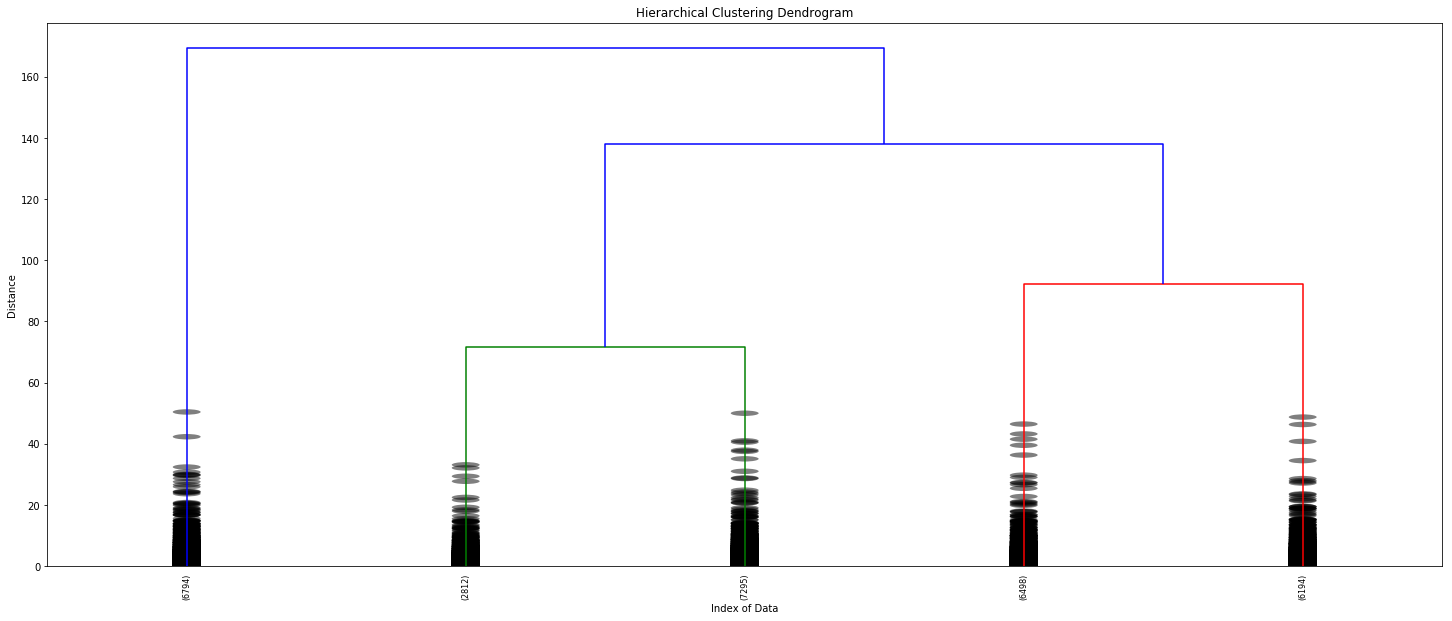

In [21]:
# Plot dendrogram with branch number (p) set
plot_dendrogram('Hierarhcical Clustering Dendrogram', 'Index of Data', 'Distance', 
                Z, p=5)

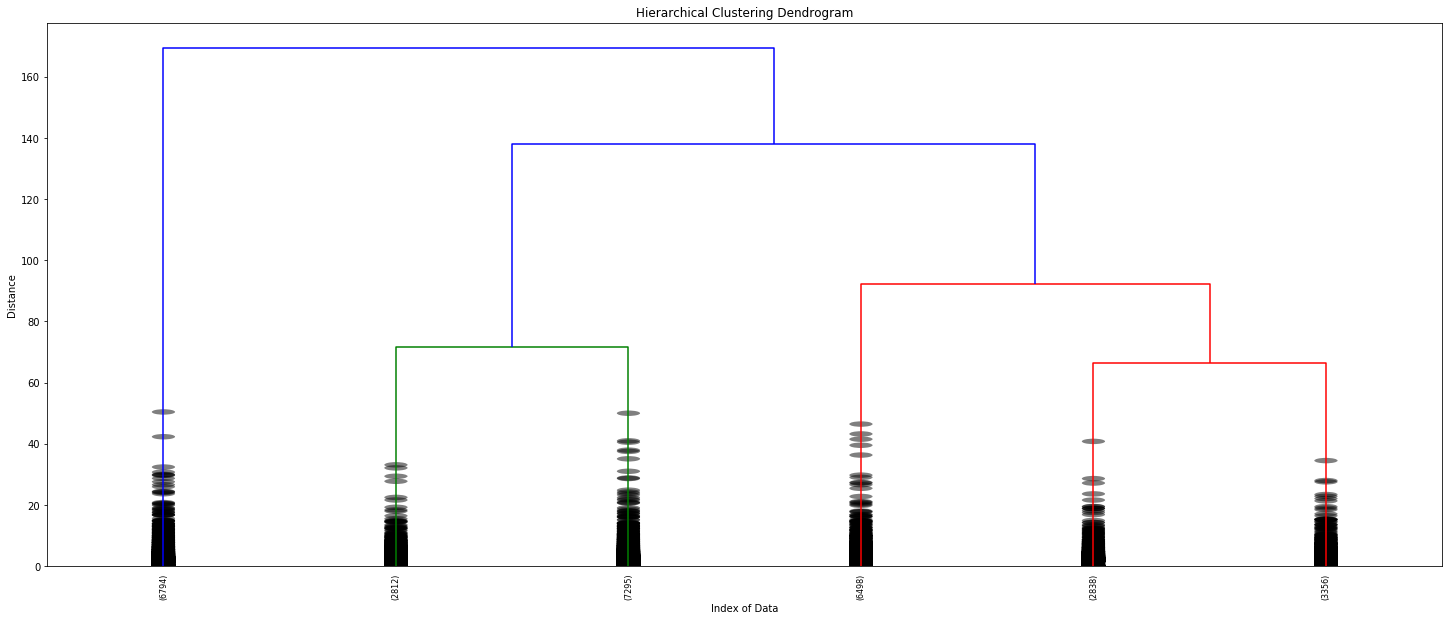

In [22]:
# Plot dendrogram when p = 6
plot_dendrogram('Hierarhcical Clustering Dendrogram', 'Index of Data', 'Distance', 
                Z, p=6)

#### k-means

In [33]:
# Fit
n_clusters = 5
kmodel = KMeans(n_clusters=n_clusters)
kmodel.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [34]:
# Predicted labels
predicted_labels = kmodel.labels_
cdf2['kmeans_labels'] = predicted_labels

In [35]:
# See if labels are well divided
collections.Counter(cdf2.kmeans_labels)

Counter({0: 6738, 1: 7243, 2: 5117, 3: 3896, 4: 6599})

### Classifying

#### Decision tree

In [36]:
# Split X, y
X, y = scaled_df, cdf2.kmeans_labels

In [37]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [38]:
# Model
class_weight = 'balanced'
max_leaf_nodes = 5
dt_model = DecisionTreeClassifier(class_weight=class_weight, max_leaf_nodes=max_leaf_nodes)
# max_depth = 5
# dt_model = DecisionTreeClassifier(class_weight=class_weight, max_depth=max_depth)
dt_model.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=5,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
# Get predictions
y_pred_dt = dt_model.predict(X=X_test)

In [40]:
# Get score
dt_model.score(X=X_test, y=y_test)

0.9041762400324368

#### Graphviz

In [41]:
# Export tree as .dot
with open('decision_tree.dot', 'w') as f:
    export_graphviz(dt_model, f, feature_names=scaled_df.columns)

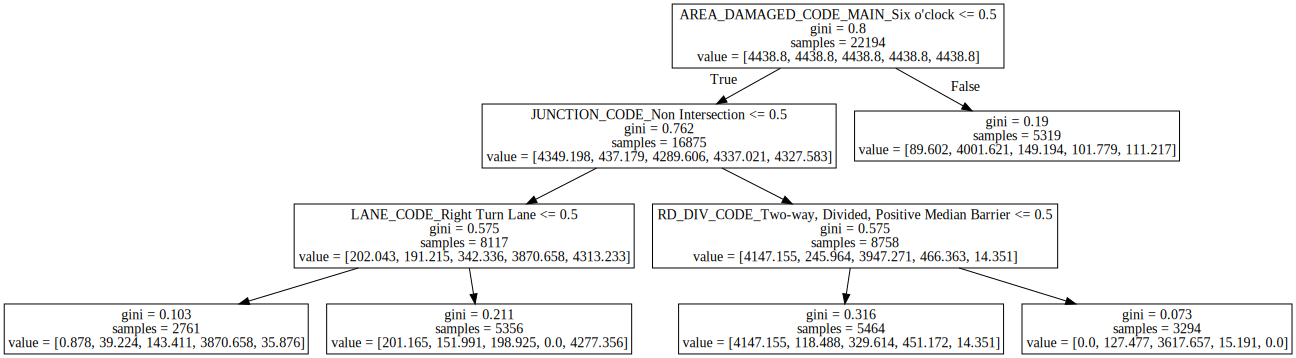

In [42]:
# Open .dot and visualize
with open('decision_tree.dot', 'r') as f:
    dot_graph = f.read()

gv.Source(dot_graph)

### Analyzing

In [54]:
# Among features chosen by the decision tree above, pick two with the highest severity level
# Because INJ_SEVER_CODE is skewed, give heavy weight by replacing
d = {'INJ_SEVER_CODE': {
    'Fatal Injury': 1024,
    'Incapacitating/Disabled Injury': 64,
    'Possible Incapacitating Injury': 8,
    'Non-incapacitating Injury': 2,    
    'No Injury': 1
}}
cdf3 = cdf.replace(d)

# severity == normalized class frequency * normalized class average injury severity
cls1 = cdf3[cdf3['AREA_DAMAGED_CODE_MAIN'] == 'Six o\'clock']
cls2 = cdf3[
    (cdf3['AREA_DAMAGED_CODE_MAIN'] != 'Six o\'clock')
    & (cdf3['JUNCTION_CODE'] == 'Non Intersection')
    & (cdf3['RD_DIV_CODE'] == 'Two-way, Divided, Positive Median Barrier')
]
cls3 = cdf3[
    (cdf3['AREA_DAMAGED_CODE_MAIN'] != 'Six o\'clock')
    & (cdf3['JUNCTION_CODE'] != 'Non Intersection')
    & (cdf3['LANE_CODE'] == 'Right Turn Lane')
]

cls_list = [cls1, cls2, cls3]

freq_list = []
avg_list = []
d = {}
for cls in cls_list:
    freq = cls.count().iloc[0]
    freq_list.append(freq)
    avg = cls['INJ_SEVER_CODE'].mean()
    avg_list.append(avg)
    d[freq] = avg

print(freq_list)
print(avg_list)

[7091, 4386, 7137]
[2.1644337893103933, 2.7637938896488827, 3.1206389239176127]


In [55]:
# Normalize then get severity
freq_arr = np.array(freq_list)
avg_arr = np.array(avg_list)

sever_d = {}
for i, (f, a) in enumerate(d.items()):
    norm_f = (f - np.mean(freq_arr)) / np.std(freq_arr)
    norm_a = (a - np.mean(avg_arr)) / np.std(avg_arr)
    sever_d[i] = norm_f * norm_a

# Get two highest features
collections.Counter(sever_d).most_common(2)

[(2, 0.80420113585506547), (1, -0.2897370150332701)]

In [60]:
collections.Counter(cls3['INJ_SEVER_CODE'])

Counter({1: 5772, 2: 486, 8: 813, 64: 61, 1024: 5})

In [61]:
collections.Counter(cls2['INJ_SEVER_CODE'])

Counter({1: 3690, 2: 244, 8: 409, 64: 41, 1024: 2})

In [62]:
collections.Counter(df['INJ_SEVER_CODE'])

Counter({'Fatal Injury': 26,
         'Incapacitating/Disabled Injury': 239,
         'No Injury': 24451,
         'Non-incapacitating Injury': 1751,
         'Possible Incapacitating Injury': 3126})